In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import make_env
from stable_baselines3 import PPO
from scipy.optimize import minimize
import time
import pickle
sns.set_style('whitegrid')

In [44]:
def load_agents(qr1=(1,1), qr2=(1,5), qrt=(1,3), g=1, noise=None):
    env1 = make_env('1', q=qr1[0], r=qr1[1], goal=g)
    env2 = make_env('2', q=qr2[0], r=qr2[1], goal=g)
    envt = make_env('t', q=qrt[0], r=qrt[1], goal=g)


    ppo1 = PPO.load('./1216/q_'+str(qr1[0])+'_r_'+str(qr1[1])+'/Evalpoint/best_model.zip', env=env1)
    ppo2 = PPO.load('./1216/q_'+str(qr2[0])+'_r_'+str(qr2[1])+'/Evalpoint/best_model.zip', env=env2)
    ppot = PPO.load('./1216/q_'+str(qrt[0])+'_r_'+str(qrt[1])+'/Evalpoint/best_model.zip', env=envt)

    s1 = env1.reset() 
    s2 = env2.reset() 
    st = envt.reset() 
    step = 0 

    y1 = np.zeros((3, 101))
    y2 = np.zeros((3, 101))
    yt = np.zeros((3, 101))
    du1 = np.zeros((3, 100))
    du2 = np.zeros((3, 100))
    dut = np.zeros((3, 100))

    while True: 
        step += 1 
        if noise is not None: 
            attacked_s1 = s1.copy() 
            attacked_s2 = s2.copy() 
            attacked_st = st.copy()
            attacked_s1[3:6, -1] += noise[step-1, :]
            attacked_s2[3:6, -1] += noise[step-1, :]
            attacked_st[3:6, -1] += noise[step-1, :]
            a1, _ = ppo1.predict(attacked_s1, deterministic=True)
            a2, _ = ppo2.predict(attacked_s2, deterministic=True)
            at, _ = ppot.predict(st, deterministic=True)
        else:
            a1, _ = ppo1.predict(s1, deterministic=True)
            a2, _ = ppo2.predict(s2, deterministic=True)
            at, _ = ppot.predict(st, deterministic=True)
        s1_, r, d, _ = env1.step(a1)
        s2_, r, d, _ = env2.step(a2)
        st_, r, d, _ = envt.step(at)

        y1[:, step] = s1_[:3, -1] - s1_[3:6, -1]
        y2[:, step] = s2_[:3, -1] - s2_[3:6, -1]
        yt[:, step] = st_[:3, -1] - st_[3:6, -1]

        du1[:, step-1] = a1
        du2[:, step-1] = a2
        dut[:, step-1] = at

        if d: 
            break 

        s1 = s1_ 
        s2 = s2_ 
        st = st_ 

    return y1, y2, yt, du1, du2, dut

In [45]:
def difference(w, yt, du1, du2, win, ans='norm'):
    '''
    method used to calculate the output of the next sampling time,
    using w to get du = w * du1 + (1 - w) * du2 to be close to yt
    @param w: the sequential parameter to be solved  
    @param yt: target y at the next sampling time
    @param yu: exerted y of each u in the system 
    @param du1: du of the first base agent (smaller)
    @param du2: du of the second base agent (larger)
    @param win: length of a single moving window 
    '''
    # du: n x 3
    w = w.reshape(-1, 3)
    n = int(np.floor(100 / win))
    re = (n - 1) * [win] + [win + 100 % win]
    w_ = np.repeat(w, re, axis=0)
    # w = np.repeat(w, win * [100/win], axis=0)
    du1 = du1.reshape(-1, 3)
    du2 = du2.reshape(-1, 3)
    u1 = np.cumsum(du1, axis=0) * 0.05
    u2 = np.cumsum(du2, axis=0) * 0.05

    u = w_ * u1 + (1 - w_) * u2

    yk = [np.array([0, 0, 0])] 
    yu = np.zeros((3, 3))
    res = []
    for i in range(yt.shape[0]-1):
        res.append(0.9 * np.linalg.norm(yt[i, :] - yk[i]) + 0.1 * np.linalg.norm(yt[i, :] - 1))
        yu1 = np.array([0.9231, 0.9231, 0.8858]) * yu[0, :]
        # u1 -> y1  
        if i >= 6:
            yu1[0] += 0.082 * u[i-6, 0]
        if i >= 7:
            yu1[0] += 0.2312 * u[i-7, 0]
        # u1 -> y2 
        if i >= 4:
            yu1[1] += 0.2113 * u[i-4, 0]
        if i >= 5:
            yu1[1] += 0.2031 * u[i-5, 0]
        # u1 -> y3 
        if i >= 5:
            yu1[2] += 0.5 * u[i-5, 0]
        
        yu2 = np.array([0.9355, 0.9355, 0.9131]) * yu[1, :]
        # u2 -> y1  
        if i >= 7:
            yu2[0] += 0.1142 * u[i-7, 1]
        # u2 -> y2 
        if i >= 3:
            yu2[1] += 0.1875 * u[i-3, 1]
        if i >= 4:
            yu2[1] += 0.1814 * u[i-4, 1]
        # u2 -> y3 
        if i >= 5:
            yu2[2] += 0.1964 * u[i-5, 1]
        if i >= 6:
            yu2[2] += 0.1877 * u[i-6, 1]

        yu3 = np.array([0.9231, 0.9048, 0.8102]) * yu[2, :]
        # u3 -> y1  
        if i >= 6:
            yu3[0] += 0.1164 * u[i-6, 2]
        if i >= 7:
            yu3[0] += 0.3356 * u[i-7, 2]
        # u3 -> y2 
        if i >= 3:
            yu3[1] += 0.1704 * u[i-3, 2]
        if i >= 4:
            yu3[1] += 0.4863 * u[i-4, 2]
        # u3 -> y3 
        yu3[2] += 1.367 * u[i, 2]

        yu = np.array([yu1, yu2, yu3])
        yk.append(yu1 + yu2 + yu3)
    if ans == 'norm':
        return np.sum(res)
    elif ans == 'info':
        '''
        return yk, yu
        '''
        return np.stack(yk), u, res

In [46]:
def cons1(x, du1, du2, win):
    u1 = np.cumsum(du1, axis=0) * 0.05
    u2 = np.cumsum(du2, axis=0) * 0.05
    n = int(np.floor(100 / win))
    x = x.reshape(-1, 3)
    re = (n - 1) * [win] + [win + 100 % win] 
    x_ = np.repeat(x, re, axis=0)
    u = x_ * u1 + (1 - x_) * u2
    du = u[1:, :] - u[:-1, :]
    return -np.prod(0.05-du+1e-8>0) - np.prod(du+0.05+1e-8>0) + 2 - 1e-8

def draw(y1, y2, yt, yk):
    fig, axs = plt.subplots(3, 1, figsize=(12, 6), dpi=100)
    axs[0].plot(y1.T[:, 0], color='r', label='base 1')
    axs[0].plot(y2.T[:, 0], color='b', label='base 2')
    axs[0].plot(yt.T[:, 0], color='g', label='target')
    axs[0].plot(yk[:, 0], color='black', linestyle='--', label='PDRL')
    axs[0].set_ylabel('$y_1$')

    axs[1].plot(y1.T[:, 1], color='r')
    axs[1].plot(y2.T[:, 1], color='b')
    axs[1].plot(yt.T[:, 1], color='g')
    axs[1].plot(yk[:, 1], color='black', linestyle='--')
    axs[1].set_ylabel('$y_2$')

    axs[2].plot(y1.T[:, 2], color='r')
    axs[2].plot(y2.T[:, 2], color='b')
    axs[2].plot(yt.T[:, 2], color='g')
    axs[2].plot(yk[:, 2], color='black', linestyle='--')
    axs[2].set_ylabel('$y_3$')
    axs[2].set_xlabel('$step$')

    axs[0].legend()

    for ax in axs:
        ax.set_xlim([0, 100])

In [54]:
wins = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
# wins = [5, 20, 30, 50, 100]
times = 1
mean = []
std = [] 
mean_noise = []
std_noise = []

basic_case_noise = [np.random.normal(0, 0.1, (100, 3)) for _ in range(times)]
general_case_noise = [np.random.normal(0, 0.2, (100, 3)) for _ in range(times)]

In [55]:
for win in wins:
    iae = []
    for t in range(times):
        print('----------------- start processing win {} -----------------'.format(win))
        print('----------------- {} / {} -----------------'.format(t, times))
        qr1 = (1, 1)
        qr2 = (1, 5)
        qrt = (1, 3)
        goal = 1
        y1, y2, yt, du1, du2, dut = load_agents(qr1, qr2, qrt, g=goal, noise=basic_case_noise[t])

        # win = 30
        step = 100
        n = int(np.floor(100 / win))
        x0 = np.ones((n, 3)) * 0.5  

        con1 = {
            'type': 'ineq',
            'fun': cons1,
            'args': (du1.T, du2.T, win)
        }

        print('----------------- start optimization -----------------')
        t1 = time.time() 
        res = minimize(
            fun=difference,
            x0=x0,
            args=(yt.T, du1.T, du2.T, win, 'norm'),
            method='SLSQP',
            bounds=tuple([(0, 1) for _ in range(np.prod((n, 3)))]),
            constraints=(con1),
            options={'maxiter':200, 'disp':True}
        )
        t2 = time.time() 
        print('----------------- optimization done -----------------')
        print('time consumption: {:.3f} seconds'.format(t2-t1))

        '''
        reshow the fitting performance  
        '''
        yk, u, r = difference(res.x.reshape(-1, 3), yt.T, du1.T, du2.T, win, ans='info')

        '''
        draw 
        '''
        # draw(y1, y2, yt, yk)

        '''
        generalization 
        '''
        y1, y2, yt, du1, du2, dut = load_agents(qr1, qr2, qrt, g=2, noise=general_case_noise[t])
        yk, u, r = difference(res.x.reshape(-1, 3), yt.T, du1.T, du2.T, win, ans='info')
        # draw(y1, y2, yt, yk)
        t = np.arange(1, 102, 1).reshape(-1, 1)
        iae.append(np.sum(np.abs(yk-yt.T)))
    mean.append(np.mean(iae))
    std.append(np.std(iae))

    # plt.show()

----------------- start processing win 1 -----------------
----------------- 0 / 1 -----------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------- start optimization -----------------
Iteration limit reached    (Exit mode 9)
            Current function value: 2.7353708712236786
            Iterations: 200
            Function evaluations: 60225
            Gradient evaluations: 200
----------------- optimization done -----------------
time consumption: 146.187 seconds
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------- start processing win 3 -----------------
----------------- 0 / 1 ---------

In [136]:
data_dict = {
    'wins': wins,
    'mean': mean,
    'std': std,
    'mean_noise': mean_noise,
    'std_noise': std_noise,
    'basic_case_noise': basic_case_noise,
    'general_case_noise': general_case_noise
}

with open('./data/window_compare.pkl', 'wb') as f: 
    pickle.dump(data_dict, f)

Text(0, 0.5, '$IAE$')

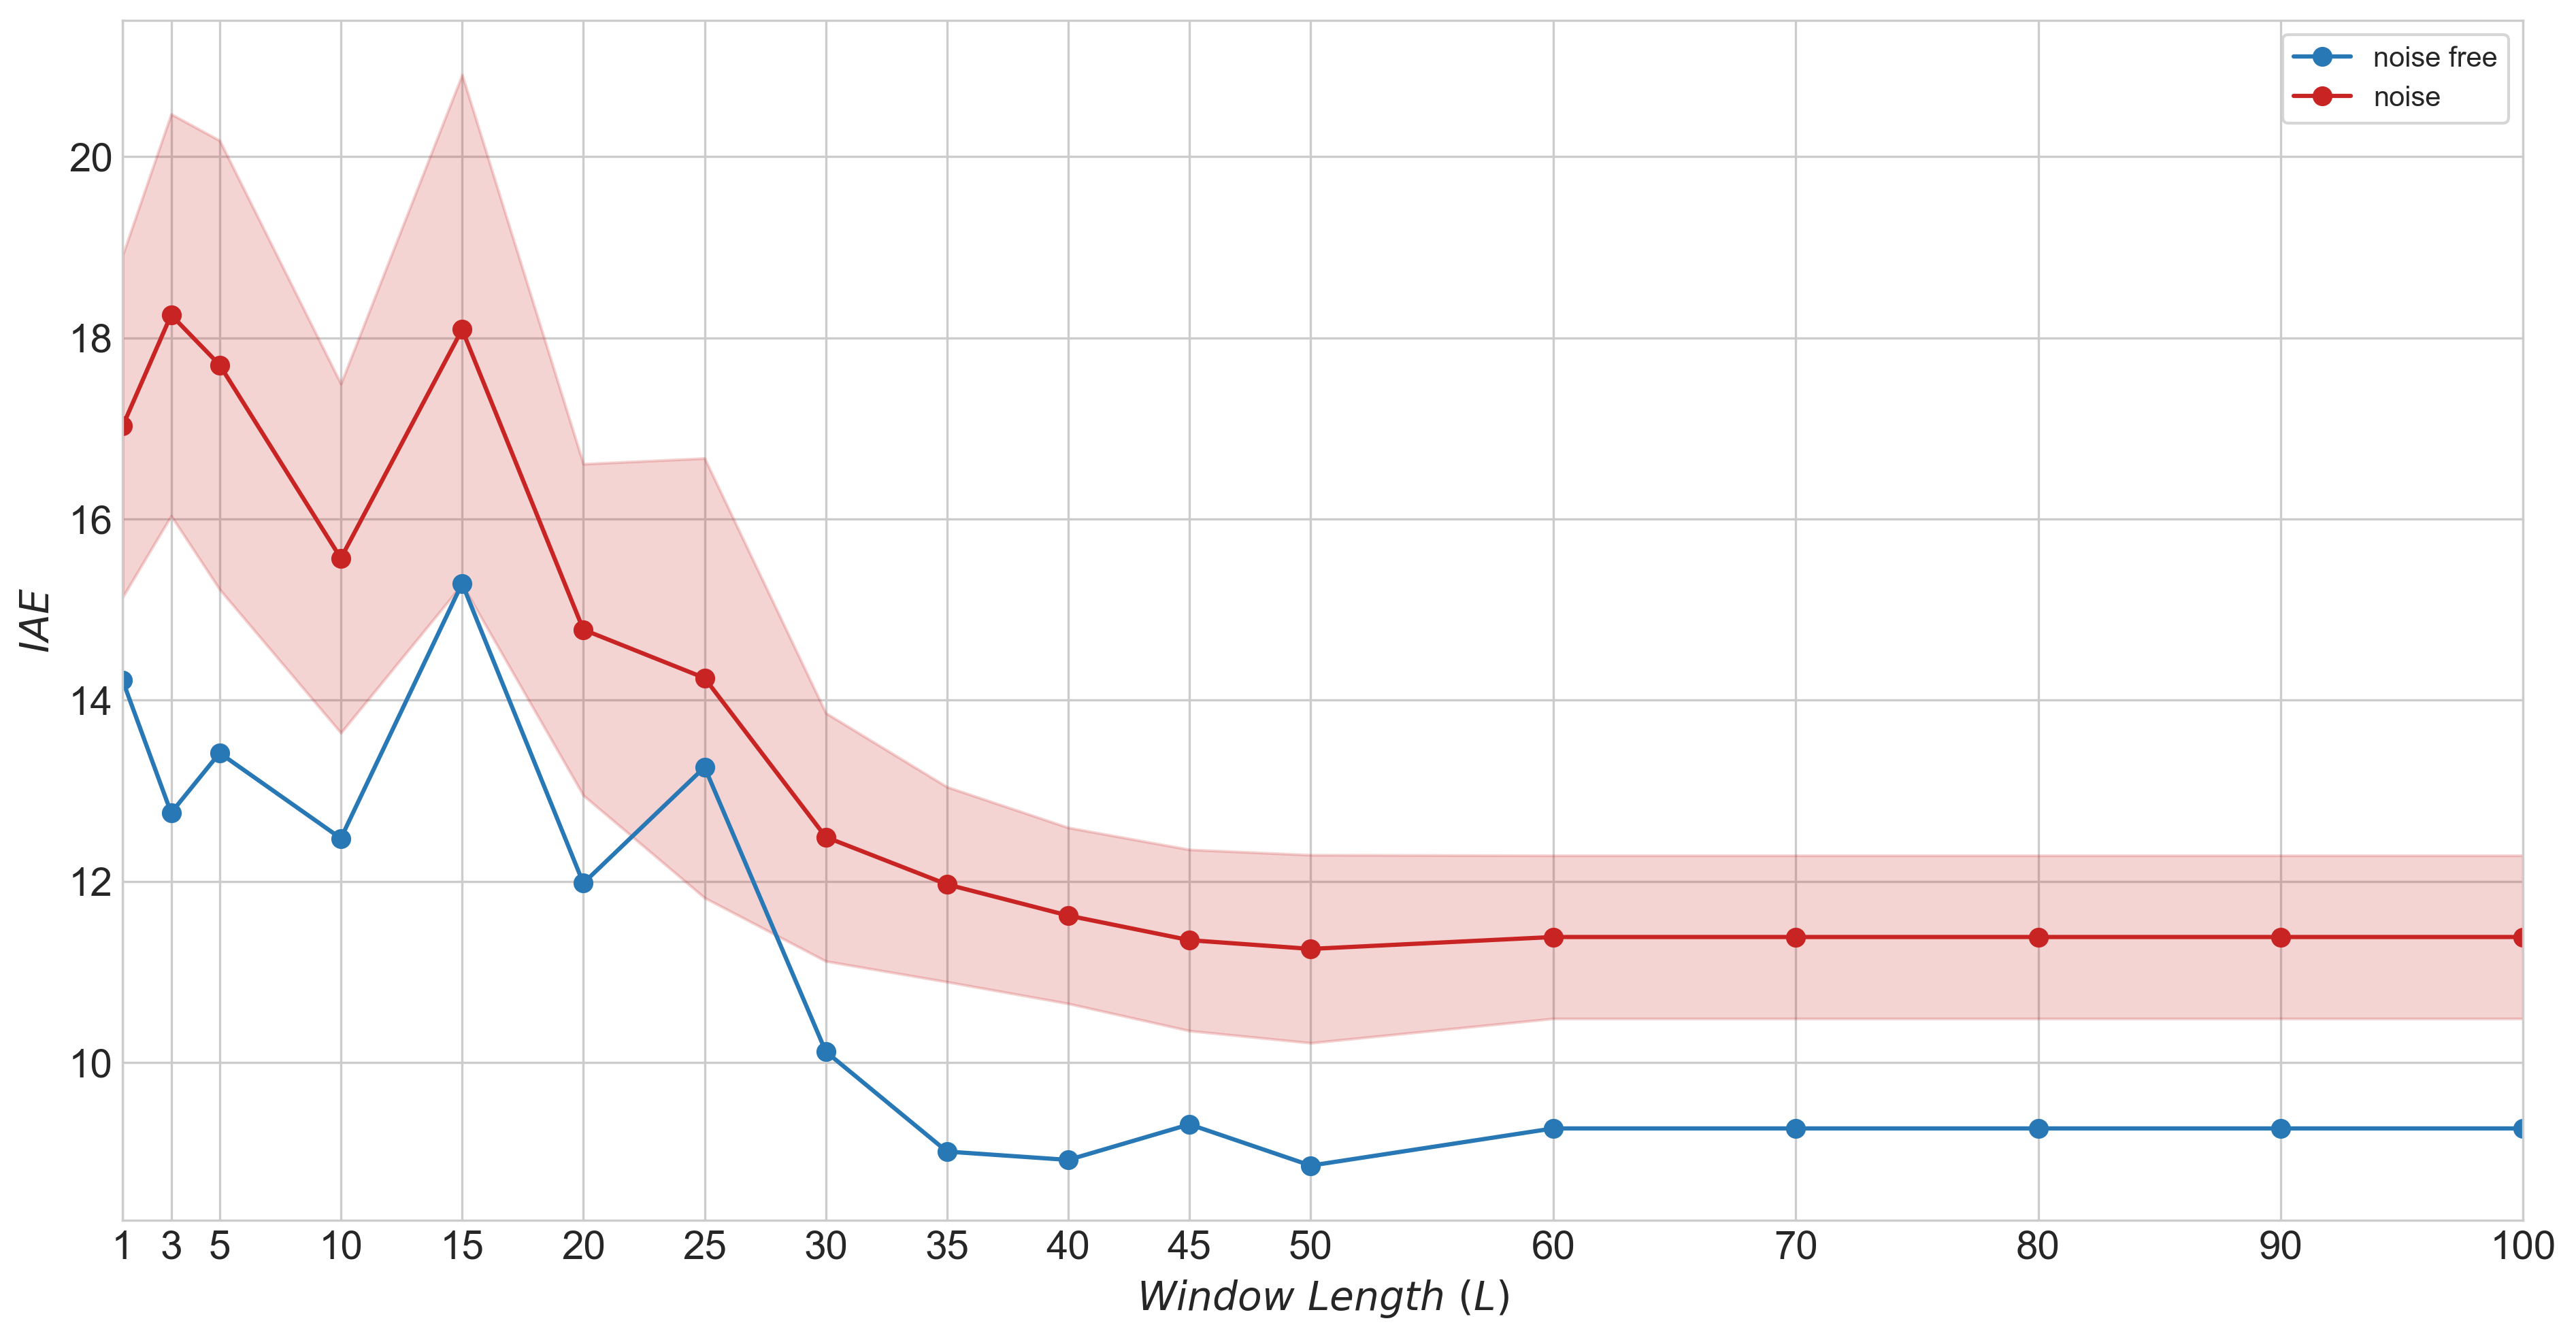

In [144]:
plt.style.use('_mpl-gallery')

# x = wins
# y = mean 
# yerr = [s for s in std]

fig = plt.figure(figsize=(12, 6), dpi=300)

# plt.errorbar(wins, mean, fmt='o', linewidth=2, capsize=6, mfc='#2878B5', mec='#2878B5')
# plt.errorbar(wins, mean_noise, [s*0.5 for s in std_noise], fmt='o', linewidth=2, capsize=6, ecolor='orangered', mfc='#C82423', mec='#C82423')
plt.plot(wins, mean, marker='o', c='#2878B5', label='noise free')
yerr = [s*0.5 for s in std_noise]
plt.fill_between(wins, np.array(mean_noise)-np.array(yerr), np.array(mean_noise)+np.array(yerr), color='#C82423', alpha=0.2)
plt.plot(wins, mean_noise, marker='o', c='#C82423', label='noise', )
plt.legend()
plt.xlim([1, 100])
plt.xticks(wins, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$Window\ Length\ (L)$', fontsize=14)
plt.ylabel('$IAE$', fontsize=14)

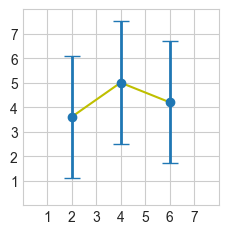

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
np.random.seed(1)
x = [2, 4, 6]
y = [3.6, 5, 4.2]
yerr = [2.5]

# plot:
fig, ax = plt.subplots()

ax.errorbar(x, y, yerr, fmt='o', linewidth=2, capsize=6)
ax.plot(x, y, 'y')

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()